In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
#### SVM
from sklearn.svm import SVC
from sklearn.metrics import classification_report, matthews_corrcoef, precision_score,recall_score, accuracy_score, confusion_matrix
#
from feature_extraction_copy import feature_extraction
from functions import get_model_results
#
from scipy.stats import fisher_exact, mannwhitneyu, sem

### Dataset preparation

In [2]:
training = pd.read_table('../clean_metadata_training')
benchmarking = pd.read_table('../clean_metadata_benchmarking')
#positives_train = training[training['Signal peptide'].isnull() == False]
#negatives_train = training[training['Signal peptide'].isnull() == True]
training['class'] = 0
training.loc[training['Signal peptide'].notna(), 'class'] = 1
#
benchmarking['class'] = 0
benchmarking.loc[benchmarking['Signal peptide'].notna(), 'class'] = 1

### Benchmarking on a blind set

We test on a blid set the most perfomative model found during the cross validation

In [3]:
#model
model_combination = 'SVM-comp-transmem_tendency-global_comp-hp_global'
global_comp= True
hp = False
hp_global = True
charge = False
h_tendency =False
transmem_tendency = True
glob_transmem_tendency = False

In [4]:
#hyperparamters
C =  8
gamma = 2
K =  22

X_train,Y_train = feature_extraction(training,K,global_comp=global_comp,hp=hp,hp_global=hp_global,charge=charge,h_tendency=h_tendency,transmem_tendency=transmem_tendency,glob_transmem_tendency =glob_transmem_tendency)
X_test, Y_test = feature_extraction(benchmarking,K,global_comp=global_comp,hp=hp,hp_global=hp_global,charge=charge,h_tendency=h_tendency,transmem_tendency=transmem_tendency,glob_transmem_tendency =glob_transmem_tendency)

model = SVC(C=C, kernel='rbf', gamma=gamma)
model.fit(X_train[1:],Y_train)
Y_test_pred= model.predict(X_test[1:])
mcc_test = matthews_corrcoef(Y_test,Y_test_pred)
acc_test = accuracy_score(Y_test,Y_test_pred)
prec_test = precision_score(Y_test,Y_test_pred)
recall_test = recall_score(Y_test,Y_test_pred)
#
blind_set_results = {'model':[model_combination],'K':[K],'gamma':[gamma],'C':[C],'MCC val':['/'],'MCC test':[mcc_test],'ACC':[acc_test],'precision':[prec_test],'recall':[recall_test]}

blind_set_results = pd.DataFrame.from_dict(blind_set_results).round(2)


blind_set_results


,model,K,gamma,C,MCC val,MCC test,ACC,precision,recall
0,SVM-comp-transmem_tendency-global_comp-hp_global,22,2,8,/,0.89,0.98,0.93,0.87


In [5]:
blind_set_results.to_csv('results/benchSVM_results_prova.tsv',mode='a',sep='\t',header=False) 

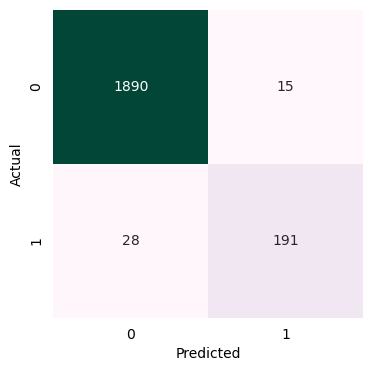

In [6]:
cm = confusion_matrix(Y_test, Y_test_pred)

plt.figure(figsize=(4, 4))
heatmap2 = sns.heatmap(cm, annot=True, fmt="d", cmap='PuBuGn', cbar=False)
heatmap2.tick_params(left=False, bottom=False)
heatmap2.set(xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("figures/confusion_matrices_benchmark.svg", bbox_inches='tight')


## FP analyses

In [7]:
benchmarking['pred_class'] = Y_test_pred


In [8]:
#save negative to do fp
benchmarking[benchmarking['class']==0][['Entry','class','pred_class']].to_csv('benchmark_negative.tsv',sep='\t',index=False)
fpr = np.round(cm[0][1]/(cm[0][1]+cm[0][0]),decimals=3)
print('General FPR: %s' % (fpr*100)+'%')

General FPR: 0.8%


In [9]:
benchmark_neg = benchmarking[benchmarking['class']==0][['Entry','pred_class']]
benchmark_neg['TM']=0
with open('../vonHeijne/fp_analysis/neg_transmem') as file:
    tm_subset = [line.strip() for line in file]
benchmark_neg['TM'] = benchmark_neg['Entry'].isin(tm_subset).astype(int)

tp_subset = pd.read_table('../vonHeijne/fp_analysis/neg_transit',sep='\t',names=['Entry','TP_location'])
benchmark_neg = pd.merge(benchmark_neg,tp_subset,on='Entry',how = 'outer')
benchmark_neg.insert(loc=3, column='TP', value=0)
benchmark_neg.loc[benchmark_neg['TP_location'].notna(), 'TP'] = 1
benchmark_neg

,Entry,pred_class,TM,TP,TP_location
0,Q9H444,0,0,0,NaN
1,Q8S8D3,0,0,0,NaN
2,Q9FG00,0,1,0,NaN
3,P82929,0,0,0,NaN
4,Q00IB6,0,0,0,NaN
...,...,...,...,...,...
1900,G5EGF8,0,0,0,NaN
1901,Q8WXI9,0,0,0,NaN
1902,Q3EBC8,0,0,0,NaN
1903,Q8I615,0,0,0,NaN


### FPR_TM

In [10]:
tm_FP = benchmark_neg[(benchmark_neg['TM']==1) & (benchmark_neg['pred_class']==1)].shape[0]
tm = benchmark_neg[(benchmark_neg['TM']==1)].shape[0]
FPR_tm =np.round((tm_FP/tm)*100,decimals=2)
print('FPR_TM: %s' % (FPR_tm)+'%')
#



FPR_TM: 4.7%


### FPR_TP

In [11]:
tp_FP = benchmark_neg[(benchmark_neg['TP']==1) & (benchmark_neg['pred_class']==1)].shape[0]
tp = benchmark_neg[(benchmark_neg['TP']==1)].shape[0]
FPR_tp =np.round((tp_FP/tp)*100,decimals=1)
print('FPR_TP: %s' % (FPR_tp)+'%')

FPR_TP: 0.5%


### FPR_TM and FPR_TP visualization


In [12]:

benchmark_neg.loc[benchmark_neg['pred_class'] == 1,'pred_class']='FP'
benchmark_neg.loc[benchmark_neg['pred_class'] == 0,'pred_class']='TN'
################################################################################################
tm_df = benchmark_neg[benchmark_neg['TM']==1][['pred_class','TM']]
tm_df['feature'] = 'Transmembrane'
#
tp_df = benchmark_neg[benchmark_neg['TP']==1][['pred_class','TP']]
tp_df['feature'] = 'Transit peptide'
#
tm_tp = pd.concat((tm_df[['pred_class','feature']],tp_df[['pred_class','feature']]),ignore_index=True)
tm_tp


,pred_class,feature
0,TN,Transmembrane
1,TN,Transmembrane
2,TN,Transmembrane
3,TN,Transmembrane
4,TN,Transmembrane
...,...,...
360,TN,Transit peptide
361,TN,Transit peptide
362,TN,Transit peptide
363,TN,Transit peptide


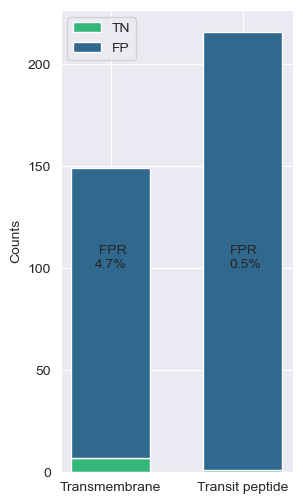

In [13]:

#palette = {"TN":"#CCB3B5","FP":"#4D191F"}
sns.set_style("darkgrid")
plt.figure(figsize=(3, 6))
sns.histplot(data=tm_tp,x = 'feature',hue='pred_class',alpha=1,stat='count',multiple='stack',common_norm=False,shrink=0.6,palette='viridis')
plt.legend(title='', labels=['TN', 'FP'])
plt.xlabel('')
plt.ylabel('Counts')
plt.text(-0.12, 100, f' FPR\n{FPR_tm}%', fontsize=10)
plt.text(0.9, 100, f'FPR\n{FPR_tp}%', fontsize=10)
plt.savefig("figures/FPR_TMandFPR_TP.svg",bbox_inches='tight')


### Over-representation of transmembrane proteins in FP with respect to TN


In [14]:

benchmark_neg.loc[benchmark_neg['TM'] == 1,'TM']='Transmembrane'
benchmark_neg.loc[benchmark_neg['TM'] == 0,'TM']='Non-Transmembrane'
benchmark_neg.loc[benchmark_neg['TP'] == 1,'TP']='Transit peptide'
benchmark_neg.loc[benchmark_neg['TP'] == 0,'TP']='Non-Transit peptide'
pivot_df = benchmark_neg.pivot_table(index='pred_class', columns='TM', values='Entry', aggfunc='count', fill_value=0)
columns_titles = ['Transmembrane',"Non-Transmembrane"] #change cols order
pivot_df = pivot_df.reindex(columns=columns_titles)
OR, p_val = fisher_exact(pivot_df)
p_val = '{:0.2e}'.format(p_val)


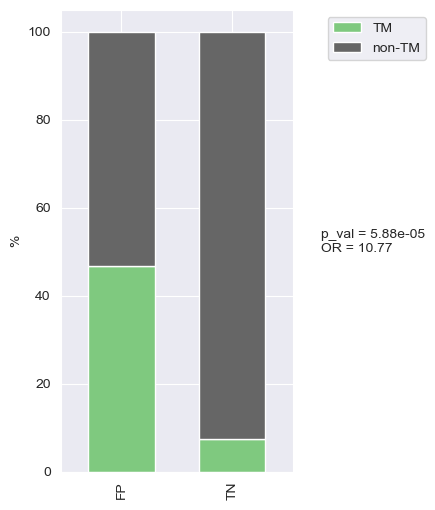

In [15]:

# 
pivot_df['Total'] = pivot_df['Transmembrane'] + pivot_df['Non-Transmembrane']
pivot_df['Transmembrane_Percentage'] = (pivot_df['Transmembrane'] / pivot_df['Total']) * 100
pivot_df['Non_transmembrane_Percentage'] = (pivot_df['Non-Transmembrane'] / pivot_df['Total']) * 100

pivot_df = pivot_df[['Transmembrane_Percentage', 'Non_transmembrane_Percentage']]
# Create the stacked barplot
plt.rcParams['figure.figsize'] = [3, 6]
pivot_df[['Transmembrane_Percentage', 'Non_transmembrane_Percentage']].plot(kind='bar', stacked=True, colormap='Accent',width=0.6)
#plt.title('TM percentages by classes')
plt.xlabel('')
plt.ylabel('%')
plt.legend(title='', loc='upper right', labels=['TM','non-TM'], bbox_to_anchor=(1.6, 1))
plt.text(1.8, 50, f'p_val = {p_val}\nOR = {OR:.2f}', fontsize=10)
plt.savefig("figures/ORofTMinFP.svg", bbox_inches='tight')


### Over-representation of transit peptide proteins in FP with respect to TN


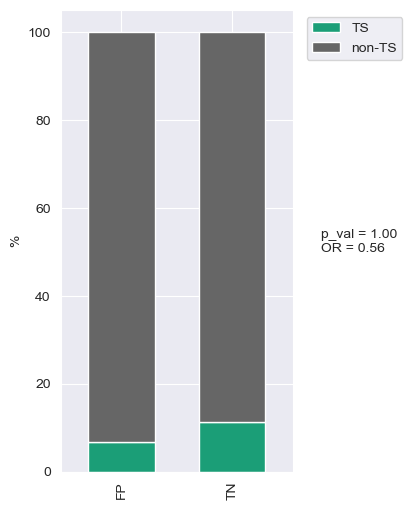

In [16]:

pivot_df2 = benchmark_neg.pivot_table(index='pred_class', columns='TP', values='Entry', aggfunc='count', fill_value=0)
#
columns_titles = ['Transit peptide',"Non-Transit peptide"]
pivot_df2=pivot_df2.reindex(columns=columns_titles)
OR, p_val = fisher_exact(pivot_df2)
# 
pivot_df2['Total'] = pivot_df2['Transit peptide'] + pivot_df2['Non-Transit peptide']
pivot_df2['Transit peptide_Percentage'] = (pivot_df2['Transit peptide'] / pivot_df2['Total']) * 100
pivot_df2['Non_Transit-peptide_Percentage'] = (pivot_df2['Non-Transit peptide'] / pivot_df2['Total']) * 100
pivot_df = pivot_df[['Transmembrane_Percentage', 'Non_transmembrane_Percentage']]
#
plt.rcParams['figure.figsize'] = [3, 6]
pivot_df2[['Transit peptide_Percentage', 'Non_Transit-peptide_Percentage']].plot(kind='bar', stacked=True, colormap='Dark2',width=0.6)
#plt.title('TP by classes')
plt.xlabel('')
plt.ylabel('%')
plt.legend(title='', labels=['TS', 'non-TS'], bbox_to_anchor=(1.5, 1))
plt.text(1.8, 50, f'p_val = {p_val:.2f}\nOR = {OR:.2f}', fontsize=10)
plt.savefig("figures/ORofTPinFP.svg", bbox_inches='tight')


## FN analyses

In [17]:
#FNR (FN/FN+TP) or miss rate
fn = cm[1,0]
fnr =  np.round(cm[1,0]/(cm[1,0]+cm[1,1])*100,decimals=3)
print('FNR: %s' % (fnr)+'%')

FNR: 12.785%


#### Compare SP len of FNs VS TPs (Mann-Whitney U)

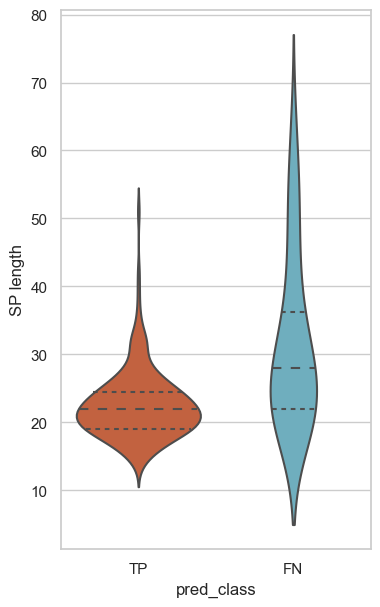

In [18]:
positives = benchmarking[benchmarking['class']==1]
#MWU pval
tp_len = np.array(positives[positives['pred_class']==1]['Signal peptide'])
fn_len = np.array(positives[positives['pred_class']==0]['Signal peptide'])
U1,p_val = mannwhitneyu(fn_len, tp_len, use_continuity=True, alternative='greater', axis=0, method='auto')
#
positives.loc[positives['pred_class']==1,'pred_class'] = 'TP'
positives.loc[positives['pred_class']==0,'pred_class'] = 'FN'
#
sns.set(style="darkgrid")
plt.figure(figsize=(4, 7))

sns.set(rc={"figure.figsize":(4, 6)},style = 'whitegrid') 
sns.violinplot(data=positives, y="Signal peptide",x='pred_class',inner='quartile',palette=['#d8572a','#62b6cb'])
plt.ylabel('SP length')#plt.text(-0.3, 65, f'MWU p-val = {p_val:.4f}', fontsize=12)
plt.savefig("figures/SPlength_FN.svg", bbox_inches='tight')

## FN vs TP N-COMP (:K)

In [19]:
euc_freq = {'M': 2.294367689100498, 'R': 5.28659479524882, 'F': 4.061144192552833, 'Q': 4.243880060805525, 'V': 6.195116301658416, 'I': 5.2782038449558515, 'A': 6.964597776165187, 'T': 5.474762802434163, 'S': 8.167359184996902, 'Y': 2.9958458540998643, 'P': 5.352921291956602, 'G': 6.4210338295777225, 'D': 5.162172071912705, 'L': 9.66490107039764, 'N': 4.366213941365931, 'K': 5.957815728327312, 'E': 6.579050194696789, 'H': 2.411104159651493, 'W': 1.2401562853801333, 'C': 1.882758924715616}
euc_freq = pd.DataFrame(euc_freq.items(),columns=['aa','%'])

In [20]:
#TP
#note that are present Z,U,X letters too
tp_comp = {'Z' :0,'U' :0,'X' :0,'A': 0, 'Q': 0, 'L': 0, 'S': 0, 'R': 0, 'E': 0, 'K': 0, 'T': 0, 'N': 0, 'G': 0, 'M': 0, 'W': 0, 'D': 0, 'H': 0, 'F': 0, 'Y': 0, 'C': 0, 'I': 0, 'P': 0, 'V': 0}
for index, row in positives.iterrows():
    if row['pred_class']=='TP':
        for char in row["Sequence"][:K]:
            tp_comp[char] += 1
#remove strange aa
aa_to_remove = ['X','Z','U']
for key in aa_to_remove:
    tp_comp.pop(key)
#normalize the frequencies
factor=sum(tp_comp.values())/100
for k in tp_comp.keys():
    tp_comp[k] = tp_comp[k]/factor
#FN
#note that are present Z,U,X letters too
fn_comp = {'Z' :0,'U' :0,'X' :0,'A': 0, 'Q': 0, 'L': 0, 'S': 0, 'R': 0, 'E': 0, 'K': 0, 'T': 0, 'N': 0, 'G': 0, 'M': 0, 'W': 0, 'D': 0, 'H': 0, 'F': 0, 'Y': 0, 'C': 0, 'I': 0, 'P': 0, 'V': 0}
for index, row in positives.iterrows():
    if row['pred_class']=='FN':
        for char in row["Sequence"][:K]:
            fn_comp[char] += 1
#remove strange aa
aa_to_remove = ['X','Z','U']
for key in aa_to_remove:
    fn_comp.pop(key)
#normalize the frequencies
factor=sum(fn_comp.values())/100
for k in fn_comp.keys():
    fn_comp[k] = fn_comp[k]/factor

In [21]:
amino_acid_groups = {
    'polar': ['S', 'T', 'N', 'Q', 'H','C'],
    'apolar': ['G', 'A', 'V', 'P', 'L', 'I', 'M'],
    'charged': [ 'D', 'E', 'K', 'R'],
    'aromatic': ['F', 'W', 'Y']}
aa_order = ['G','A','V','P','L','I','M','D','E','K','R','F','W','Y','S','T','C','N','Q','H']     
tp_comp = pd.DataFrame(tp_comp.items(),columns=['aa','%'])
fn_comp = pd.DataFrame(fn_comp.items(),columns=['aa','%'])
tp_comp['set'] = 'TP'
fn_comp['set'] = 'FN'
df_composition = pd.concat((tp_comp, fn_comp),ignore_index=True)

euc_freq['group'] = euc_freq['aa'].apply(lambda x: next((group for group, aas in amino_acid_groups.items() if x in aas), None))
df_composition['group'] = df_composition['aa'].apply(lambda x: next((group for group, aas in amino_acid_groups.items() if x in aas), None))


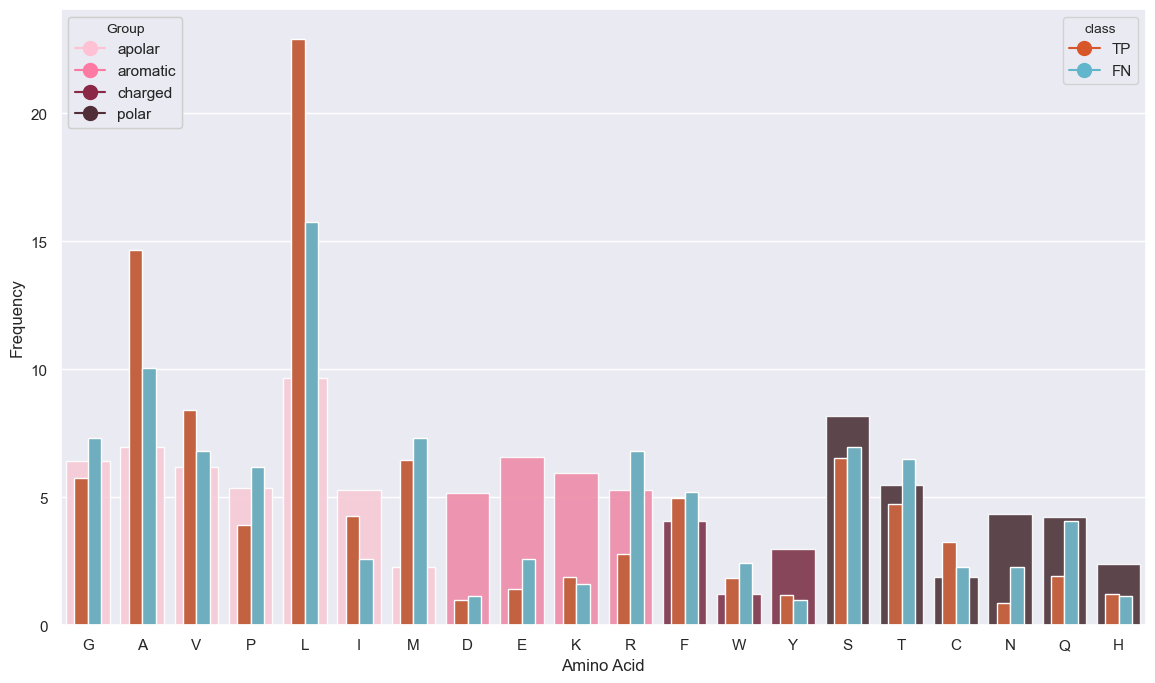

In [22]:
#graph
#plot the training and the benchmarking frequencies over the background frequencies
sns.set(style="darkgrid")
plt.figure(figsize=(14, 8))

sns.barplot(data=euc_freq, x='aa', y='%',hue='group', palette=['#ffc2d4','#ff7aa2','#8a2846','#522e38'], order=aa_order, dodge=False, width=0.8, alpha=0.9)
sns.barplot(data=df_composition, x='aa', y='%', hue='set', palette=['#d8572a','#62b6cb'], width=0.5, order = aa_order)

#['#222E50','#007991','#439A86','#BCD8C1']['#ff9505','#ffc971']
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
#plt.title('Differences in amino acid composition at the N-terminal in TP and FN (vs SwissProt-eukaryotes)')

# Define custom legend labels, colors, and marker styles (using 'o' for circular markers)
legend_labels1 = {'TP': ('#d8572a', 'o'), 'FN': ('#62b6cb', 'o')}
legend_labels2 = {'apolar': ('#ffc2d4', 'o'), 'aromatic': ('#ff7aa2', 'o'), 'charged': ('#8a2846', 'o'), 'polar': ('#522e38', 'o')}

# Create custom legend handles (lines with circular markers) and labels for the first plot
legend_handles1 = [plt.Line2D([], [], color=color, marker=marker, markersize=10, label=label) for label, (color, marker) in legend_labels1.items()]
legend_labels1 = list(legend_labels1.keys())  # Use the legend labels as-is

# Create custom legend handles (lines with circular markers) and labels for the second plot
legend_handles2 = [plt.Line2D([], [], color=color, marker=marker, markersize=10, label=label) for label, (color, marker) in legend_labels2.items()]
legend_labels2 = list(legend_labels2.keys())  # Use the legend labels as-is

# Create a custom legend for the first plot
legend1 = plt.legend(handles=legend_handles1, title="class", loc="upper right", labels=legend_labels1)
legend1.get_title().set_fontsize('10')  # Adjust the legend title font size here

# Create a custom legend for the second plot
legend2 = plt.legend(handles=legend_handles2, title="Group", loc="upper left", labels=legend_labels2)
legend2.get_title().set_fontsize('10')  # Adjust the legend title font size here


# Add both legends to the plot
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.savefig("figures/Ncomp_FNTP.svg", bbox_inches='tight')
#plt.legend(title='Legend', loc='upper right')


### C-COMP 

In [23]:
#TP
#note that are present Z,U,X letters too
tp_comp = {'Z' :0,'U' :0,'X' :0,'A': 0, 'Q': 0, 'L': 0, 'S': 0, 'R': 0, 'E': 0, 'K': 0, 'T': 0, 'N': 0, 'G': 0, 'M': 0, 'W': 0, 'D': 0, 'H': 0, 'F': 0, 'Y': 0, 'C': 0, 'I': 0, 'P': 0, 'V': 0}
for index, row in positives.iterrows():
    if row['pred_class']=='TP':
        for char in row["Sequence"][K:]:
            tp_comp[char] += 1
#remove strange aa
aa_to_remove = ['X','Z','U']
for key in aa_to_remove:
    tp_comp.pop(key)
#normalize the frequencies
factor=sum(tp_comp.values())/100
for k in tp_comp.keys():
    tp_comp[k] = tp_comp[k]/factor
#FN
#note that are present Z,U,X letters too
fn_comp = {'Z' :0,'U' :0,'X' :0,'A': 0, 'Q': 0, 'L': 0, 'S': 0, 'R': 0, 'E': 0, 'K': 0, 'T': 0, 'N': 0, 'G': 0, 'M': 0, 'W': 0, 'D': 0, 'H': 0, 'F': 0, 'Y': 0, 'C': 0, 'I': 0, 'P': 0, 'V': 0}
for index, row in positives.iterrows():
    if row['pred_class']=='FN':
        for char in row["Sequence"][K:]:
            fn_comp[char] += 1
#remove strange aa
aa_to_remove = ['X','Z','U']
for key in aa_to_remove:
    fn_comp.pop(key)
#normalize the frequencies
factor=sum(fn_comp.values())/100
for k in fn_comp.keys():
    fn_comp[k] = fn_comp[k]/factor


In [24]:
amino_acid_groups = {
    'polar': ['S', 'T', 'N', 'Q', 'H','C'],
    'apolar': ['G', 'A', 'V', 'P', 'L', 'I', 'M'],
    'charged': [ 'D', 'E', 'K', 'R'],
    'aromatic': ['F', 'W', 'Y']}
aa_order = ['G','A','V','P','L','I','M','D','E','K','R','F','W','Y','S','T','C','N','Q','H']     
tp_comp = pd.DataFrame(tp_comp.items(),columns=['aa','%'])
fn_comp = pd.DataFrame(fn_comp.items(),columns=['aa','%'])
tp_comp['set'] = 'TP'
fn_comp['set'] = 'FN'
df_composition = pd.concat((tp_comp, fn_comp),ignore_index=True)

euc_freq['group'] = euc_freq['aa'].apply(lambda x: next((group for group, aas in amino_acid_groups.items() if x in aas), None))
df_composition['group'] = df_composition['aa'].apply(lambda x: next((group for group, aas in amino_acid_groups.items() if x in aas), None))


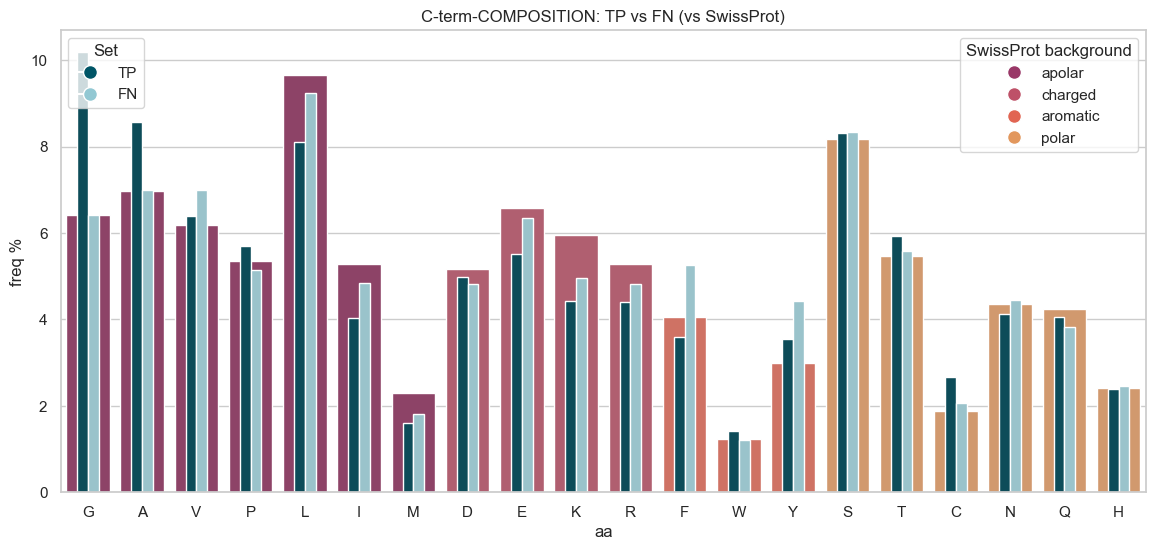

In [25]:
sns.set(rc={"figure.figsize":(14, 6)},style = 'whitegrid') 
sns.barplot(data=euc_freq,x='aa',y='%',width=0.8,order=aa_order,hue='group',alpha=1,dodge=False,palette=["#993767","#be5168","#e16552","#e2975d","#e9d78e","#3b8d9c"])
sns.barplot(data=df_composition,x='aa',y='%',hue='set',width=0.4,order=aa_order,palette=['#005566','#92C8D3']).set(title='C-term-COMPOSITION: TP vs FN (vs SwissProt)', xlabel='aa', ylabel='freq %')
# Create custom legend handles for the first legend
handles1 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in zip(euc_freq['group'].unique(), ["#993767", "#be5168", "#e16552", "#e2975d", "#e9d78e", "#3b8d9c"])]
# Create custom legend handles for the second legend
handles2 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in zip(df_composition['set'].unique(), ['#005566', '#92C8D3'])]
# Create separate legends
legend1 = plt.legend(title="SwissProt background", handles=handles1, loc='upper right')
legend2 = plt.legend(title="Set", handles=handles2, loc='upper left')
# Add the legends to the plot
plt.gca().add_artist(legend1)
plt.savefig('figures/comp.svg')